In [1]:
# Step 1: find occurrences of instances in bag of words of papers
import pandas as pd
import os
import json
import numpy as np

def csv_to_dict_of_sets(csv_file):
    dict_of_sets = {}
    # try:
    #     df = pd.read_csv(csv_file)
    # except pd.errors.ParserError:
    #     print("Error parsing CSV file. Trying again with 'error_bad_lines=False'")
    try:
        df = pd.read_csv(csv_file, on_bad_lines='warn', delimiter=";",  encoding="utf8")
    except:
        print("Error parsing CSV file. Trying again with 'encoding=ISO-8859-1'")
        df = pd.read_csv(csv_file, on_bad_lines='warn', delimiter=";", encoding='ISO-8859-1')
    for column in df.columns:
        dict_of_sets[column] = set(df[column].str.lower())
    # saved_column = df['process'] #you can also use df['column_name']
    # delete all that exists in two or more columns
    for key in dict_of_sets:
        for other_key in dict_of_sets:
            if key != other_key:
                dict_of_sets[key] = dict_of_sets[key].difference(dict_of_sets[other_key])
    return dict_of_sets

def count_occurrences(papers, instances):
    occurrences = np.zeros((len(papers), len(instances)), dtype=int)

    for p, paperpath in enumerate(papers.values()):
        with open(paperpath, 'r', encoding="utf8") as f:
            paper = json.load(f)
            for i, instance in enumerate(instances):
                present = True
                pieces = instance.split(' ')
                for piece in pieces:
                    if piece.lower() not in paper['bag_of_words']:
                        present = False
                        break
                    
                # if instance == "system integration":
                #     if "Liu und Hu - 2013 - A reuse oriented representation model for capturin" in paperpath:
                #         print(present)
                if present:
                    occurrences[p][i] = 1
    return occurrences

# ---------------------- Variables ----------------------

## instances: A set of all instances, regardless of their type
instances = set()

## instances_dicts: A dictionary of all different types (columns) of instances
#
# types:
#  - process
#  - software
#  - data item
#  - data model
#  - data format specification
#  - interchange format
#  - source
#
# instances_dicts['process']: A set of all instances of the type 'process'
#
instances_dicts = {}

## paper_nlp_dict: A dictionary of all papers and their NLP data (as dict)
paper_nlp_paths = {}

## occurrences: A matrix of binary occurrences of instances in papers
#
# rows: papers
# columns: instances
# cells: 1 if instance is present in paper, 0 otherwise
#
paperInstanceOccurrences = np.zeros((), dtype=int)

csv_file = 'C:/workspace/borgnetzwerk/tools/scripts/SLR/data.csv'
paperspath = 'G:/Meine Ablage/SE2A-B42-Aerospace-knowledge-SWARM-SLR/02_nlp'

# ---------------------- Main ----------------------

# Usage example

instances_dicts = csv_to_dict_of_sets(csv_file)

# delete sources from instances_dicts
if 'source' in instances_dicts:
    instances_dicts.pop('source')

# merge "interchange format" into "data format specification"
if 'interchange format' in instances_dicts:
    instances_dicts['data format specification'].update(instances_dicts['interchange format'])
    instances_dicts.pop('interchange format')

# merge all sets into one set
for instance_type in instances_dicts:
    instances.update(instances_dicts[instance_type])

# drop all non-text instances
instances.discard(np.nan)
# print(result)

paper_nlp_paths = {}
for file in os.listdir(paperspath):
    if file.endswith(".json"):
        paper_nlp_paths[file[:-5]] = os.path.join(paperspath, file)

paperInstanceOccurrences = count_occurrences(paper_nlp_paths, instances)

Error parsing CSV file. Trying again with 'encoding=ISO-8859-1'


In [2]:
def clean(paperInstanceOccurrences, instances):
    # total occurrences of each instance
    instance_occurrences = {}
    for i, instance in enumerate(instances):
        instance_occurrences[instance] = paperInstanceOccurrences[:, i].sum()
    instance_occurrences = {k: float(v) for k, v in sorted(instance_occurrences.items(), key=lambda item: item[1], reverse=True) if v > 0}

    with open('instance_occurrences.json', 'w', encoding="utf-8") as f:
        json.dump(instance_occurrences, f, ensure_ascii=False, indent=4)

    ## Reset instances to be a list of instances sorted by occurrences
    instances = list(instance_occurrences.keys())

    # delete all columns with only zeros
    paperInstanceOccurrences = paperInstanceOccurrences[:, np.any(paperInstanceOccurrences, axis=0)]
    return paperInstanceOccurrences, instances

In [3]:
# print instances to json
with open('instances.json', 'w', encoding="utf-8") as f:
    json.dump(list(instances), f, ensure_ascii=False, indent=4)

paperInstanceOccurrences, instances = clean(paperInstanceOccurrences, instances)

with open('instances_cleaned.json', 'w', encoding="utf-8") as f:
    json.dump(instances, f, ensure_ascii=False, indent=4)

In [4]:
# Step 2: find occurrences of instances in full text of papers
GAP_TOO_LARGE_THRESHOLD = 1000


# get all text files
directory = 'G:/Meine Ablage/SE2A-B42-Aerospace-knowledge-SWARM-SLR/00_PDFs'
paper_full_text = {}
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".txt"):
                file_path = os.path.join(folder_path, file)
                paper_full_text[file[:-4]] = file_path
                break

# find all occurrences of instances in text files
pos_in_papaer = {}

for paperID, paper in enumerate(paper_nlp_paths.keys()):
    if paperID % 100 == 0:
        print(f"Processing paper {paperID} of {len(paper_nlp_paths)}")
    if paper in paper_full_text:
        pos_in_papaer[paper] = {}
        with open(paper_full_text[paper], 'r', encoding="utf8") as f:
            text = f.read().lower()
            for i, instance in enumerate(instances):
                # if this instance is not in this document, move on.
                if not paperInstanceOccurrences[paperID][i]:
                    continue

                pieces = instance.split(' ')
                for piece in pieces:
                    piece = piece.lower()
                    if piece not in pos_in_papaer[paper]:
                        pos_in_papaer[paper][piece] = []
                        pos = 1
                        while pos > 0:
                            pos = text.find(piece, pos)
                            if pos != -1:
                                pos_in_papaer[paper][piece].append(pos)
                                # make sure this instance cannot be found again
                                pos += 1
                                # Idea: store the sentence in which the instance was found

Processing paper 0 of 1028
Processing paper 100 of 1028
Processing paper 200 of 1028
Processing paper 300 of 1028
Processing paper 400 of 1028
Processing paper 500 of 1028
Processing paper 600 of 1028
Processing paper 700 of 1028
Processing paper 800 of 1028
Processing paper 900 of 1028
Processing paper 1000 of 1028


In [5]:
# def find_min_distance_nested(list_of_lists, input_list = []):
#     min_distance = float('inf')
#     candidate_lists = []
#     for value in list_of_lists[0]:
#         new_list = input_list + [value]
#         if len(list_of_lists) > 1:
#             candidate_lists += find_min_distance_nested(list_of_lists[1:], new_list)
#         else:
#             candidate_lists.append(new_list)
#     if input_list:
#         return candidate_lists
#     else:
#         # we are the root:
#         for candidate_list in candidate_lists:
#             distance = max(candidate_list) - min(candidate_list)
#             if distance < min_distance:
#                 min_distance = distance
#         return min_distance
    
def find_min_distance(lists):
    import sys
    
    # Initialize pointers for each of the lists
    pointers = [0] * len(lists)
    min_distance = sys.maxsize
    for list in lists:
        if not list:
            # There are cases where e.g. "system integration" is not found in full text
            # This happens when NLP converts e.g. "integrated" to "integration"
            # example:
            # "Liu und Hu - 2013 - A reuse oriented representation model for capturin"
            # "system integration" -> "integration" is not found in the full text
            return -1
    while True:
        # Get the current elements from the lists
        current_elements = [lists[i][pointers[i]] for i in range(len(lists))]
        
        # Calculate the current distance
        current_min = min(current_elements)
        current_max = max(current_elements)
        current_distance = current_max - current_min
        
        # Update the minimum distance
        if current_distance < min_distance:
            min_distance = current_distance
            
        # Check if we can move forward in the list containing the minimum element
        min_index = current_elements.index(current_min)
        
        # If the pointer exceeds its list length, exit the loop
        for i in range(len(lists)):
            if pointers[i] < len(lists[i]) - 1:
                break
        if pointers[min_index] + 1 >= len(lists[min_index]):
            break
        
        # Otherwise, increment the pointer
        pointers[min_index] += 1
    
    return min_distance

# # Test the function with the given lists
# lists = [[1, 2, 3, 2, 1000], [50, 1001], [100, 1002, 10000]]
# print(find_min_distance(lists))

instance_piece_gap = {}

for paperID, paper in enumerate(paper_nlp_paths.keys()):
    if paperID % 100 == 0:
        print(f"Processing paper {paperID} of {len(paper_nlp_paths)}")
    if paper in paper_full_text:
        for i, instance in enumerate(instances):
            # if this instance is not in this document, move on.
            #TODO This does not work
            if not paperInstanceOccurrences[paperID][i]:
                continue

            pieces = instance.split(' ')
            if len(pieces) > 1:
                # print(f"Processing {instance} in {paper}")
                candidate_postions = []
                for piece in pieces:
                    candidate_postions.append(pos_in_papaer[paper][piece])
                min_distance = find_min_distance(candidate_postions)

                # min_distance_nested = find_min_distance_nested(candidate_postions)
                # print(f"{instance}: {min_distance} vs {min_distance_nested}")
                # if min_distance != min_distance_nested:
                #     print(f"Error: {min_distance} != {min_distance_nested}")

                # Pieces to far apart are not counted
                if min_distance > GAP_TOO_LARGE_THRESHOLD:
                    paperInstanceOccurrences[paperID][i] = 0
                
                # Some pieces may not be found in the full text
                if min_distance == -1:
                    paperInstanceOccurrences[paperID][i] = 0
                    # for these, we do not store the gap                    
                    continue

                if instance not in instance_piece_gap:
                    instance_piece_gap[instance] = {}
                instance_piece_gap[instance][paper] = min_distance

paperInstanceOccurrences, instances = clean(paperInstanceOccurrences, instances)

Processing paper 0 of 1028
Processing paper 100 of 1028
Processing paper 200 of 1028
Processing paper 300 of 1028
Processing paper 400 of 1028
Processing paper 500 of 1028
Processing paper 600 of 1028
Processing paper 700 of 1028
Processing paper 800 of 1028
Processing paper 900 of 1028
Processing paper 1000 of 1028


In [6]:
## Step 3: Binary co-occurrences of instances

coOccurrences = np.dot(paperInstanceOccurrences.T, paperInstanceOccurrences)

# sort by diagonal value (total occurrences)

def sort_new(matrix, instances_dicts,instances):
    diagonal = np.diag(matrix)
    indices = np.argsort(diagonal)[::-1]
    matrix = matrix[indices][:, indices]
    
    # sort all co_occurences back into the instances_dicts groups
    # first: all processes, then all software, then all formats, etc.
    new_order = []
    labels = []
    for instance_type in instances_dicts:
        # keys are: process, software, format, ...
        for ranked_instance in instances:
            for instance in instances_dicts[instance_type]:
                if instance == ranked_instance:
                    index = instances.index(instance)
                    new_order.append(index)
                    labels.append(instance)
                    break

    # sort co_occurrences by new_order
    matrix = matrix[new_order][:, new_order]
    return matrix, labels, new_order

sortedCoOccurrences, labels, new_order = sort_new(coOccurrences, instances_dicts, instances)

# export to csv
df = pd.DataFrame(sortedCoOccurrences, columns=labels, index=labels)
df.to_csv('co_occurrences.csv', sep=';')

In [7]:
## Step 3.1: Distance co-occurrences of instances
# for paper in pos_in_papaer:
#     for instance in instances:
#         pos_in_papaer[paper][instance].sort()

In [8]:
# analyse instance_piece_gaps

# prepare to store all data analysis as csv
import csv

path = 'C:/workspace/borgnetzwerk/tools/scripts/SLR/instance_piece_gaps.csv'

container = [
    ["Instance", "Min", "Max", "Mean", "Median", "Std"]
]

for instance, papers in instance_piece_gap.items():

    # print(f"Instance: {instance}")
    gaps = papers.values()
    # generate all kinds of statistical values
    min_gap = min(gaps)
    max_gap = max(gaps)
    mean_gap = sum(gaps) / len(gaps)
    median_gap = np.median(list(gaps))
    std_gap = np.std(list(gaps))
    container.append([instance, min_gap, max_gap, mean_gap, median_gap, std_gap])

# write to csv
with open(path, 'w', newline='') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(container)

In [9]:
# compare proximity of all instances with one antoher

# create a np zeros matrix of size instances x instances
proximity = np.zeros((len(instances), len(instances)), dtype=float)

mode = "sqrt"
# alternatives are:
# "sqrt" - 1 / (square root of the distance)
# "linear" - 1 / distance
# "binary" - 1 if distance < MAX_GAP_THRESHOLD, 0 otherwise
# "log" - 1 / log(distance) 

for paper in pos_in_papaer:
    for id1, instance1 in enumerate(labels):
        for id2, instance2 in enumerate(labels):
            if instance1 != instance2:
                if instance1 not in pos_in_papaer[paper]:
                    continue
                if instance2 not in pos_in_papaer[paper]:
                    continue
                positions1 = pos_in_papaer[paper][instance1]
                positions2 = pos_in_papaer[paper][instance2]
                if positions1 and positions2:
                    distance = find_min_distance([positions1, positions2])
                    if distance < 0:
                        # print(f"Error: {instance1} and {instance2} not found in {paper}")
                        continue
                    
                    result = 0.0
                    if distance == 0:
                        result = 1
                    elif mode == "sqrt":
                        result = 1 / np.sqrt(distance)
                    elif mode == "linear":
                        result = 1 / distance
                    elif mode == "binary":
                        result = 1 if distance < GAP_TOO_LARGE_THRESHOLD else 0
                    elif mode == "log":
                        result = 1 / np.log(distance)
                    else:
                        print("Error: unknown mode")
                        break
                    if result > 0.0:
                        proximity[id1][id2] += result

# create a copy of labels that only contains instances that are in the proximity matrix


#TODO rest doesnt seem to work, short fix implemented:
proximity_instances = []
for i, instance in enumerate(labels):
    if proximity[:, i].sum():
        proximity_instances.append(instance)
# proximity = proximity[new_order][:, new_order]


# proximity, proximity_instances = clean(proximity, instances)
# proximity, proximity_instances = sort_new(proximity, instances_dicts, proximity_instances)

# remove all rows with only zeros
proximity = proximity[np.any(proximity, axis=1)]

# remove all columns with only zeros
proximity = proximity[:, np.any(proximity, axis=0)]



# write proximity matrix to csv
path = 'C:/workspace/borgnetzwerk/tools/scripts/SLR/proximity.csv'
df = pd.DataFrame(proximity, columns=proximity_instances, index=proximity_instances)
df.to_csv('proximity.csv', sep=';')

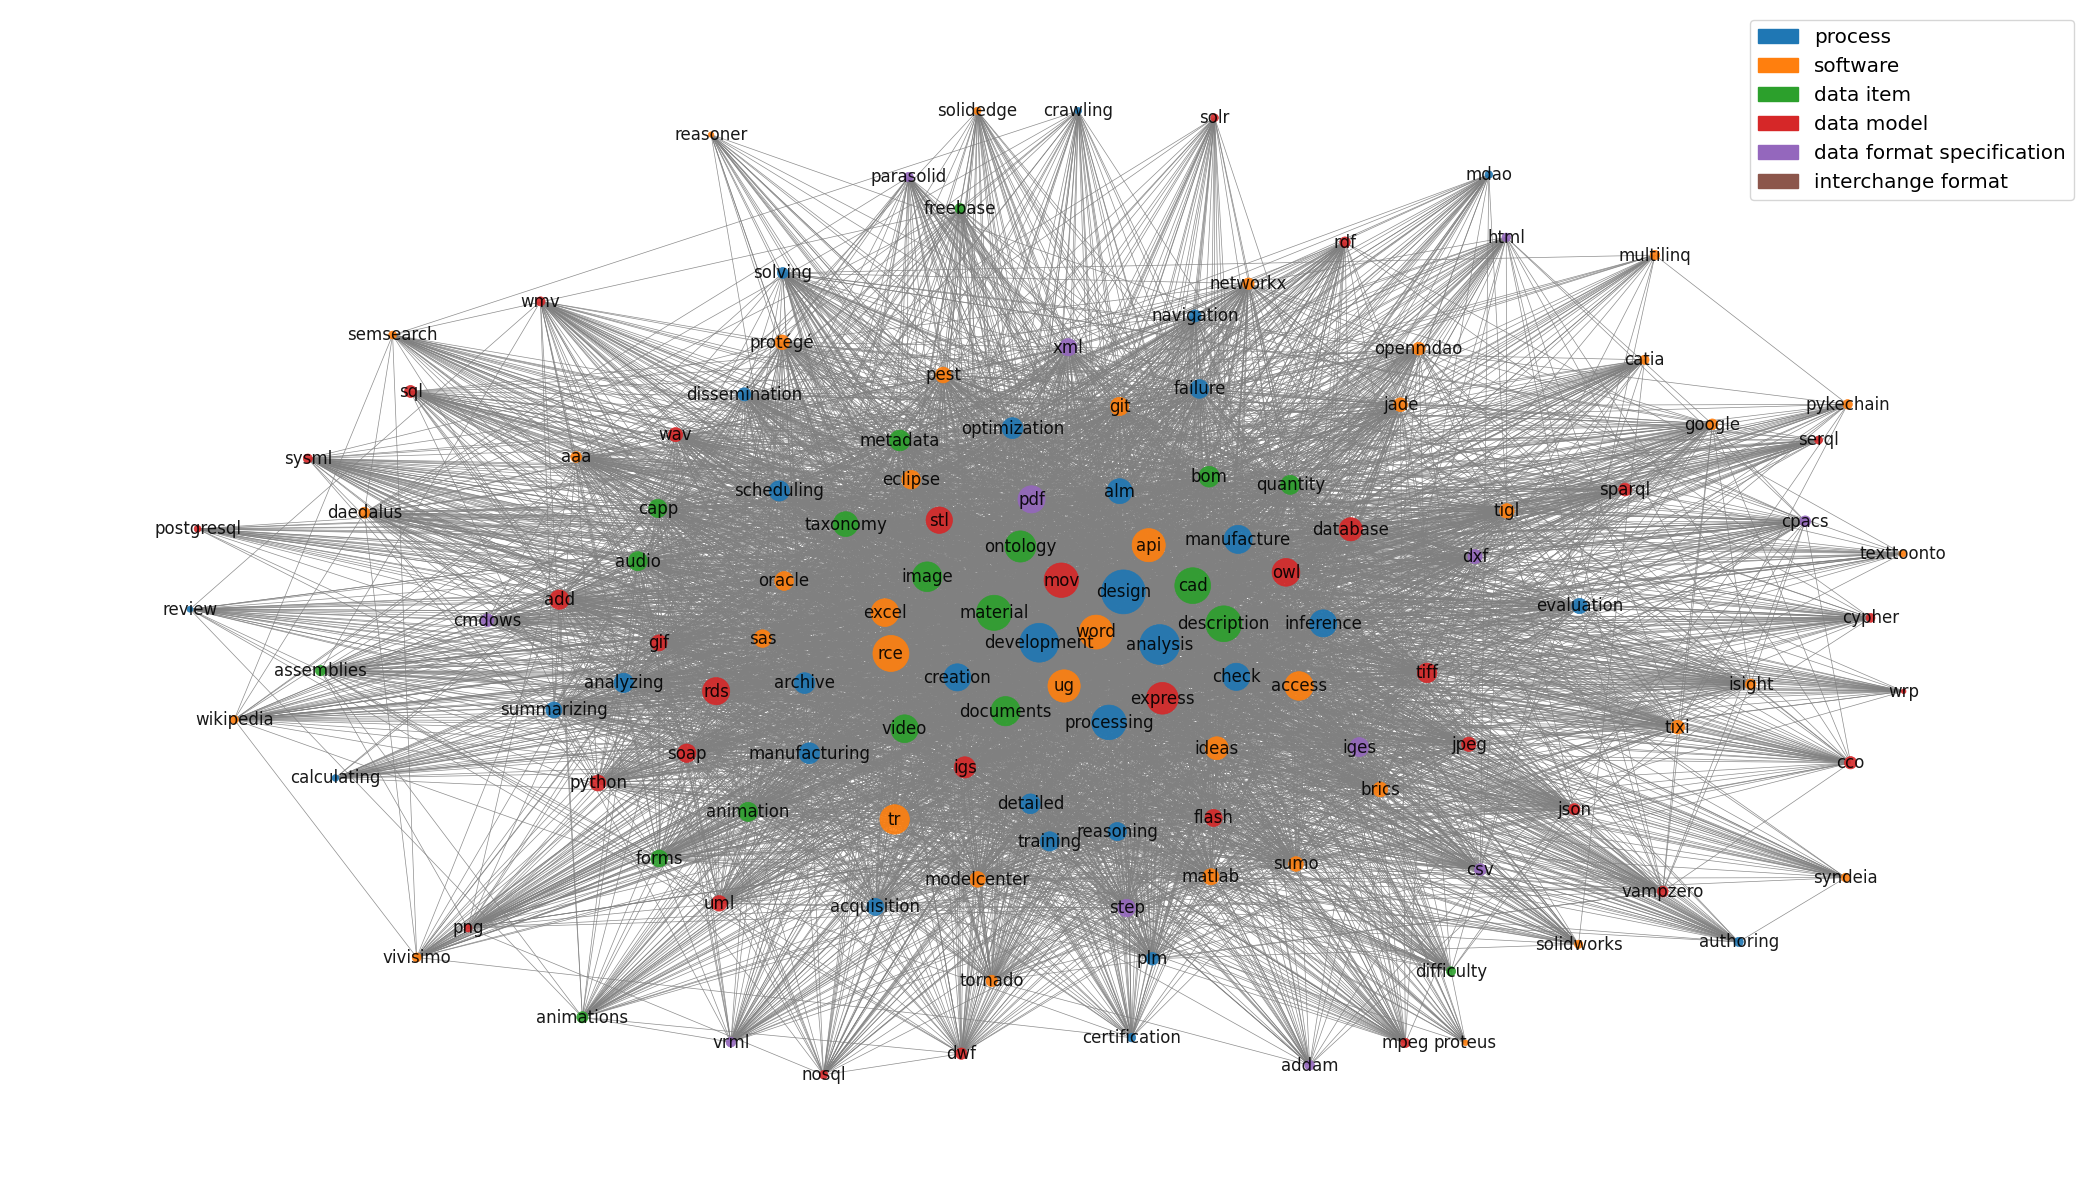

In [10]:
# visualize proximity in networkx
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

SEED = 17
K_SPRRING = 18

scale = len(proximity_instances) * .12
# Create a new figure
x = scale / 10 * 16
y = scale / 10 * 9
fig = plt.figure(figsize=(x, y))

# normalize the proximity matrix
proximity = proximity / proximity.max()

mode = "sqrt"

# alternatives are:
# "linear" - take proximity as is
# "sqrt" - sqrt(proximity)
# "log" - log(proximity)
if mode == "log":
    nodesize_map = [np.log(proximity[:, i].sum() + 1) for i in range(len(proximity_instances))]
elif mode == "sqrt":
    nodesize_map = [np.sqrt(proximity[:, i].sum()) for i in range(len(proximity_instances))]
elif mode == "linear":
    nodesize_map = [proximity[:, i].sum()for i in range(len(proximity_instances))]
else:
    nodesize_map = [proximity[:, i].sum() for i in range(len(proximity_instances))]
    
# print(max(nodesize_map))
# print(min(nodesize_map))

nodesize_map = np.array(nodesize_map) / max(nodesize_map) * 1000

# print(max(nodesize_map))
# print(min(nodesize_map))

# take the root of the proximity matrix
while np.min(proximity[np.nonzero(proximity)]) < 1/10:
    proximity = np.sqrt(proximity)

# Create a graph from the proximity matrix
G = nx.from_numpy_array(proximity)

# Specify the layout
pos = nx.spring_layout(G, seed=SEED, k=K_SPRRING/math.sqrt(G.order()))  # Seed for reproducibility

color_map = []

color = {
    "process": "#1f77b4",  # muted blue
    "software": "#ff7f0e",  # safety orange
    "data item": "#2ca02c",  # cooked asparagus green
    "data model": "#d62728",  # brick red
    "data format specification": "#9467bd",  # muted purple
    "interchange format": "#8c564b",  # chestnut brown
    # "source": "#e377c2",  # raspberry yogurt pink
}

for instance in proximity_instances:
    added = False
    for instance_type in instances_dicts:
        if instance in instances_dicts[instance_type]:
            color_map.append(color[instance_type])
            added = True
            break
    if not added:
        color_map.append("grey")

# Draw the graph
options = {
    "edge_color": "grey",
    "linewidths": 0.5,
    "width": 0.5,
    "with_labels": True,  # This will add labels to the nodes
    "labels": {i: label for i, label in enumerate(proximity_instances)},
    "node_color": color_map,
    "node_size": nodesize_map,
    "alpha": 0.9,
}

# print(nx.is_weighted(G))


# nx.set_edge_attributes(G, values = 1, name = 'weight')

nx.draw(G, pos, **options, ax=fig.add_subplot(111))

# Make the graph more spacious
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)

# Create a patch for each color
patches = [mpatches.Patch(color=color[key], label=key) for key in color]

# Add the legend to the graph
plt.legend(handles=patches, loc='upper right', fontsize='x-large')


plt.show()

# save plot to file
fig.savefig('C:/workspace/borgnetzwerk/tools/scripts/SLR/proximity_graph.png')

# nx.get_edge_attributes(G, 'weight')

In [11]:
import numpy as np
import plotly.graph_objects as go

# Convert the proximity matrix into a list of source nodes, target nodes, and values
sources = []
targets = []
values = []

x_pos=[0] * len(proximity_instances)
y_pos=[0] * len(proximity_instances)
color_map=[0] * len(proximity_instances)

max_types = len(instances_dicts)
type_positions = [0.1 + (i / max_types) * 0.8 for i in range(max_types)]

color = {
    "process": "#1f77b4",  # muted blue
    "software": "#ff7f0e",  # safety orange
    "data item": "#2ca02c",  # cooked asparagus green
    "data model": "#d62728",  # brick red
    "data format specification": "#9467bd",  # muted purple
    "interchange format": "#8c564b",  # chestnut brown
    # "source": "#e377c2",  # raspberry yogurt pink
}
color = list(color.values())

space = {}

for i in range(proximity.shape[0]):
    source_type = None

    for j in range(proximity.shape[1]):
        target_type = None
        
        for type_depth, type in enumerate(instances_dicts):
            if proximity_instances[i] in instances_dicts[type]:
                source_type = type_depth
            if proximity_instances[j] in instances_dicts[type]:
                target_type = type_depth

        # only keep directly forward moving connections
        if target_type - source_type != 1:
            continue

        # only keep forward moving connections
        if target_type - source_type <= 0:
            continue

        if source_type not in space:
            space[source_type] = {}
        if i not in space[source_type]:
            space[source_type][i] = 0
        space[source_type][i] += proximity[i][j]
        
        if target_type not in space:
            space[target_type] = {}
        if j not in space[target_type]:
            space[target_type][j] = 0
        space[target_type][j] += proximity[i][j]

        x_pos[i] = type_positions[source_type]
        x_pos[j] = type_positions[target_type]
        color_map[i] = color[source_type]
        color_map[j] = color[target_type]
        if proximity[i][j] > 0.0:  # Ignore zero values
            sources.append(i)
            targets.append(j)
            values.append(proximity[i][j])

for type in space:
    sum_values = sum(space[type].values())
    space[type] = {k: v/sum_values for k, v in sorted(space[type].items(), key=lambda item: item[1], reverse=True)}

# assign each instance a proper y position
for type in space:
    bottom = 0.1
    for i, instance in enumerate(space[type]):
        y_pos[instance] = bottom
        bottom += space[type][instance] * 0.8

nodes = dict(
    # pad=15,
    thickness=20,
    line=dict(color="black", width=0.5),
    label=proximity_instances,  # Use your labels here
    color=color_map,
    x=x_pos,
    y=y_pos,
    align="right",
)

# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=nodes,
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])


fig.update_layout(width=1920, height=1080)


fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()
fig.write_image('C:/workspace/borgnetzwerk/tools/scripts/SLR/sankey.svg')
fig.write_html("C:/workspace/borgnetzwerk/tools/scripts/SLR/sankey.html")

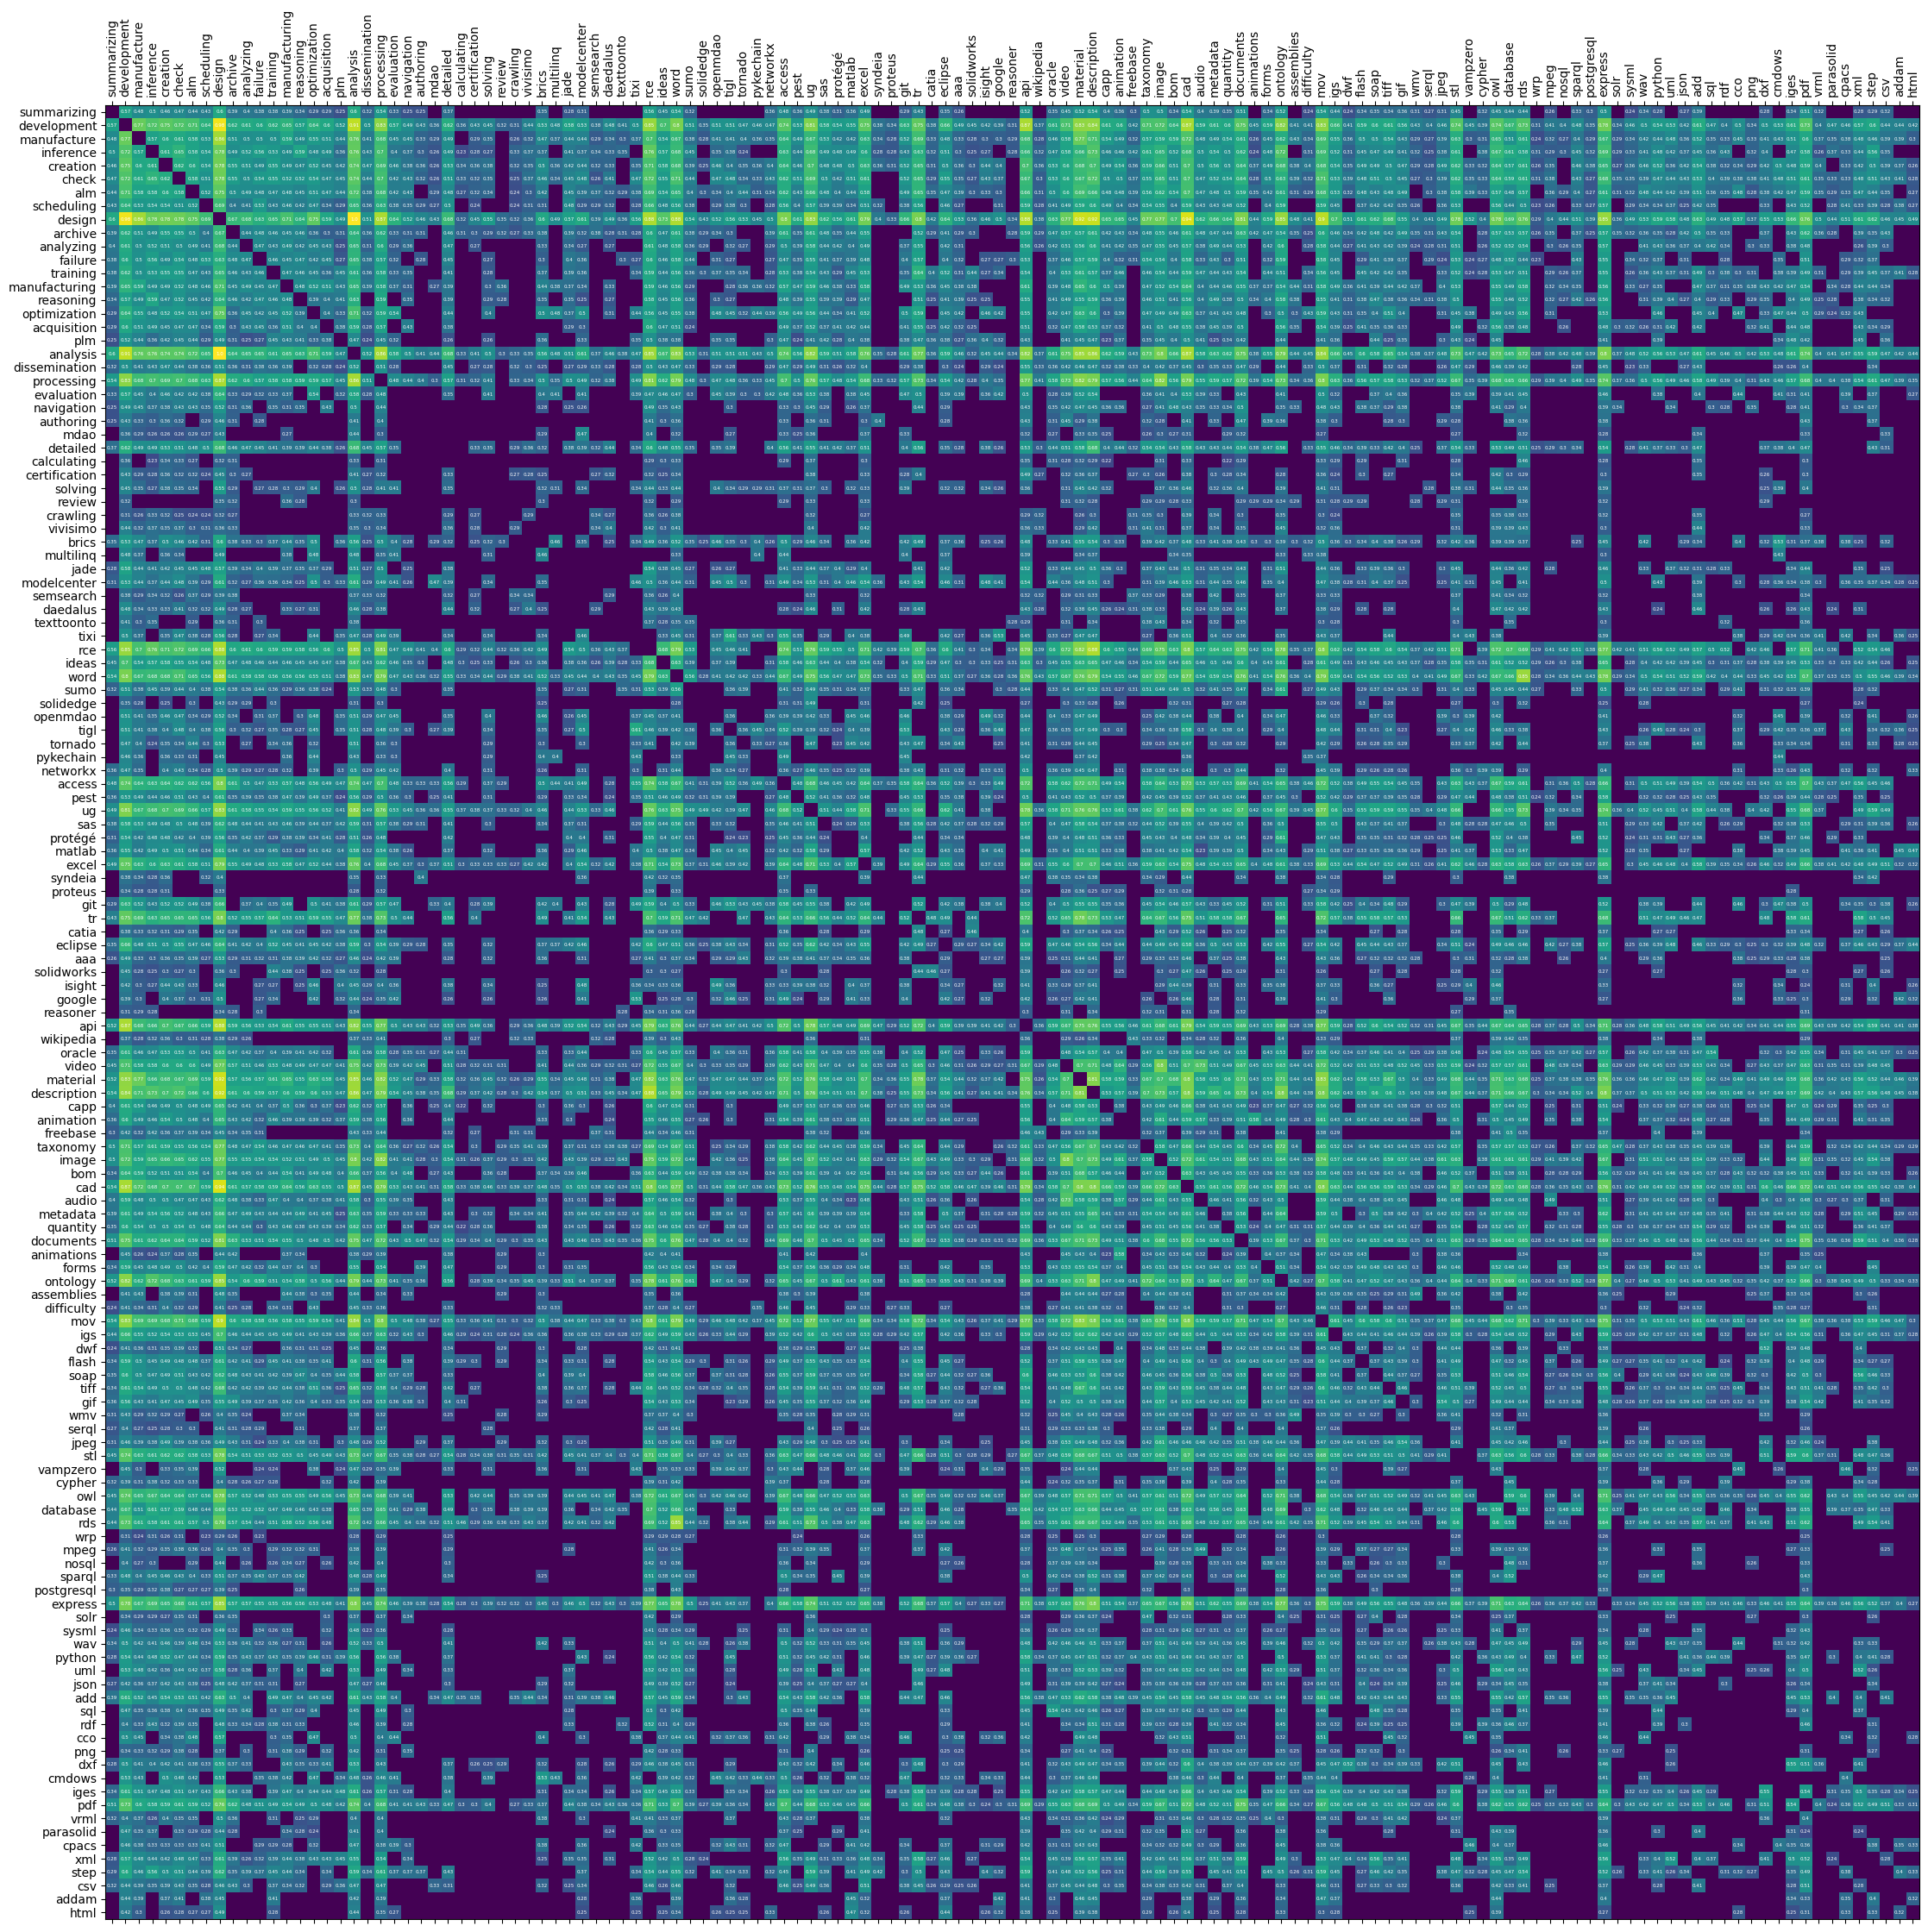

In [12]:
# visualize co-occurrences
import matplotlib.pyplot as plt
scale = len(proximity_instances) / 6
# scale = 655
fig, ax = plt.subplots(figsize=(scale, scale))

cax = ax.matshow(proximity, cmap='viridis')

# use labels from instance_occurrences
ax.set_xticks(range(len(proximity_instances)))
ax.set_xticklabels(list(proximity_instances), fontsize=10, rotation=90)
ax.set_yticks(range(len(proximity_instances)))
ax.set_yticklabels(list(proximity_instances), fontsize=10)

# # adjust the spacing between the labels
# plt.gca().tick_params(axis='x', which='major', pad=15)
# plt.gca().tick_params(axis='y', which='major', pad=15)

# show the number of co-occurences in each cell, if greater than 0
for i in range(len(proximity)):
    for j in range(len(proximity)):
        if proximity[i, j] == 0:
            continue
        # if co_occurrences[i, j] > 100:
        #     continue
        plt.text(j, i, round(proximity[i, j], 2), ha='center', va='center', color='white', fontsize=4)

# plt.show()
fig.tight_layout()

# print this plot in high resolution
fig.savefig('proximity.png', dpi=300)

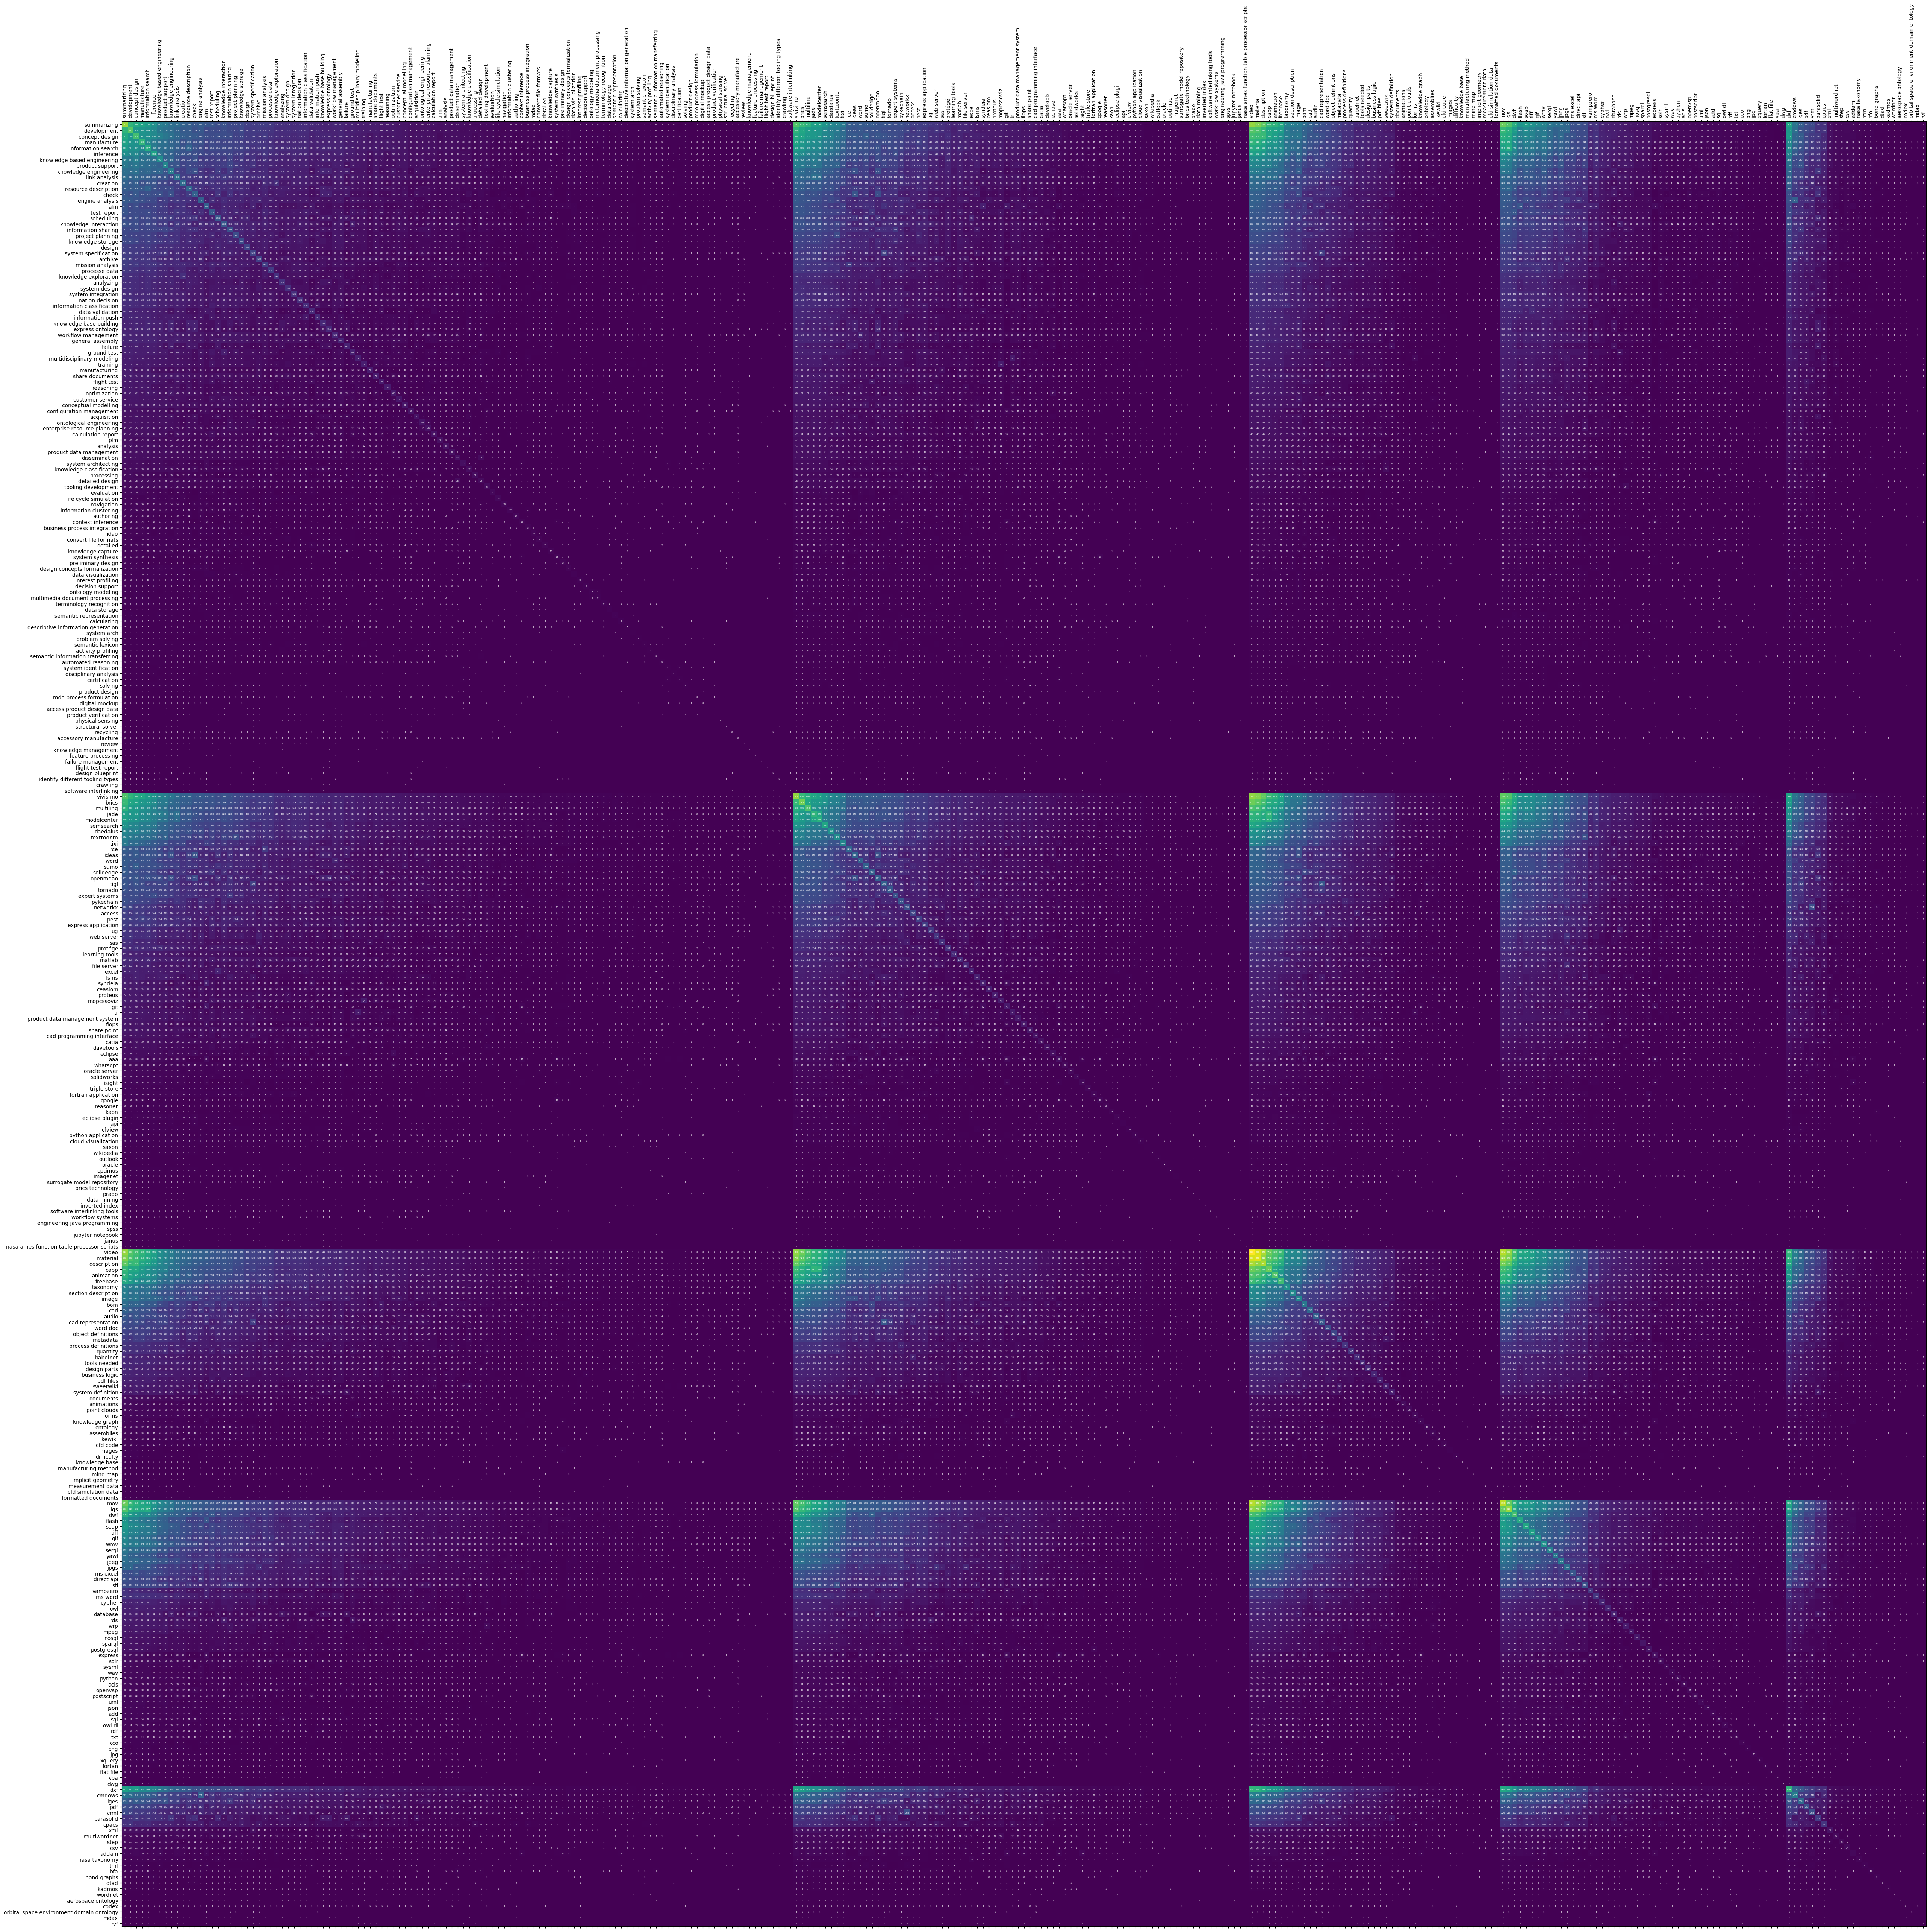

In [13]:
# visualize co-occurrences
import matplotlib.pyplot as plt
scale = len(labels) / 6
# scale = 655
fig, ax = plt.subplots(figsize=(scale, scale))

cax = ax.matshow(sortedCoOccurrences, cmap='viridis')

# use labels from instance_occurrences
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(list(labels), fontsize=10, rotation=90)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(list(labels), fontsize=10)

# # adjust the spacing between the labels
# plt.gca().tick_params(axis='x', which='major', pad=15)
# plt.gca().tick_params(axis='y', which='major', pad=15)

# show the number of co-occurences in each cell, if greater than 0
for i in range(len(sortedCoOccurrences)):
    for j in range(len(sortedCoOccurrences)):
        if sortedCoOccurrences[i, j] == 0:
            continue
        # if co_occurrences[i, j] > 100:
        #     continue
        plt.text(j, i, sortedCoOccurrences[i, j], ha='center', va='center', color='white', fontsize=4)

# plt.show()
fig.tight_layout()

# print this plot in high resolution
fig.savefig('co_occurrences_binary.png', dpi=300)